# Notebook 01: Data Exploration
**Project:** Synthetic Sleep Environment Dataset Generator  
**Authors:** Rushav Dash & Lisa Li  
**Course:** TECHIN 513 — Signal Processing & Machine Learning  
**University:** University of Washington  
**Date:** 2026-02-19

## Table of Contents
1. [Setup & Imports](#section-1)
2. [Load Datasets via DataLoader](#section-2)
3. [Sleep Efficiency EDA](#section-3)
4. [Room Occupancy EDA](#section-4)
5. [Smart Home EDA](#section-5)
6. [Reference Statistics Summary](#section-6)

---
## 1. Setup & Imports <a id='section-1'></a>
Add the project root to `sys.path` so the `src` package is importable, then bring in all third-party libraries used throughout this notebook.

In [1]:
import sys
import os

# Make the src package importable from this notebook
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import kagglehub
from scipy import signal as sp_signal

from src.data_loader import DataLoader

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
sns.set_theme(style='whitegrid')
print('Setup complete.')

Setup complete.


---
## 2. Load Datasets via DataLoader <a id='section-2'></a>
`DataLoader.download_all()` uses **kagglehub** to pull every dataset from Kaggle and caches them locally under `data/raw/`. Subsequent calls use the local cache.

In [2]:
loader = DataLoader()

print('Downloading / locating datasets...')
loader.download_all()
print('Download complete.')

[DataLoader] Downloading Sleep Efficiency dataset…


[DataLoader]   Sleep Efficiency CSV: /home/rushav/.cache/kagglehub/datasets/equilibriumm/sleep-efficiency/versions/3/Sleep_Efficiency.csv
[DataLoader] Downloading Room Occupancy dataset…


[DataLoader]   Room Occupancy CSV: /home/rushav/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2/Occupancy.csv
[DataLoader] Downloading Smart Home dataset (optional)…


[DataLoader]   Smart Home CSV: /home/rushav/.cache/kagglehub/datasets/taranvee/smart-home-dataset-with-weather-information/versions/1/HomeC.csv
Download complete.


In [3]:
df_sleep = loader.load_sleep_efficiency()
df_occ   = loader.load_room_occupancy()
df_home  = loader.load_smart_home()

print(f'Sleep Efficiency : {df_sleep.shape}')
print(f'Room Occupancy   : {df_occ.shape}')
print(f'Smart Home       : {df_home.shape if df_home is not None else "not available"}')

[DataLoader] Loaded Sleep Efficiency: 452 rows × 16 cols
[DataLoader] Loaded Room Occupancy: 20560 rows × 8 cols


[DataLoader] Loaded Smart Home: 503911 rows × 32 cols
Sleep Efficiency : (452, 16)
Room Occupancy   : (20560, 8)
Smart Home       : (503911, 32)


---
## 3. Sleep Efficiency EDA <a id='section-3'></a>
We examine the **Sleep Efficiency** dataset in detail: schema, missing values, univariate distributions, and inter-feature correlations.

In [4]:
print('=== Shape ===')
print(df_sleep.shape)
print('\n=== dtypes ===')
print(df_sleep.dtypes)
print('\n=== First 5 rows ===')
df_sleep.head()

=== Shape ===
(452, 16)

=== dtypes ===
ID                                 int64
Age                                int64
Gender                               str
Bedtime                   datetime64[us]
Wakeup time               datetime64[us]
Sleep duration                   float64
Sleep efficiency                 float64
REM sleep percentage               int64
Deep sleep percentage              int64
Light sleep percentage             int64
Awakenings                       float64
Caffeine consumption             float64
Alcohol consumption              float64
Smoking status                       str
Exercise frequency               float64
Season                               str
dtype: object

=== First 5 rows ===


,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,Season
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0,spring
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0,winter
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0,spring
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0,fall
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0,spring


In [5]:
print('=== Missing value counts ===')
null_counts = df_sleep.isnull().sum()
null_pct    = (null_counts / len(df_sleep) * 100).round(2)
pd.DataFrame({'null_count': null_counts, 'null_pct': null_pct}).query('null_count > 0')

=== Missing value counts ===


,null_count,null_pct
Awakenings,20,4.42
Caffeine consumption,25,5.53
Alcohol consumption,14,3.10
Exercise frequency,6,1.33


### 3.1 Correlation Heatmap
Pearson correlations between all numeric columns help us see which environmental and behavioural predictors are most linearly related to sleep efficiency.

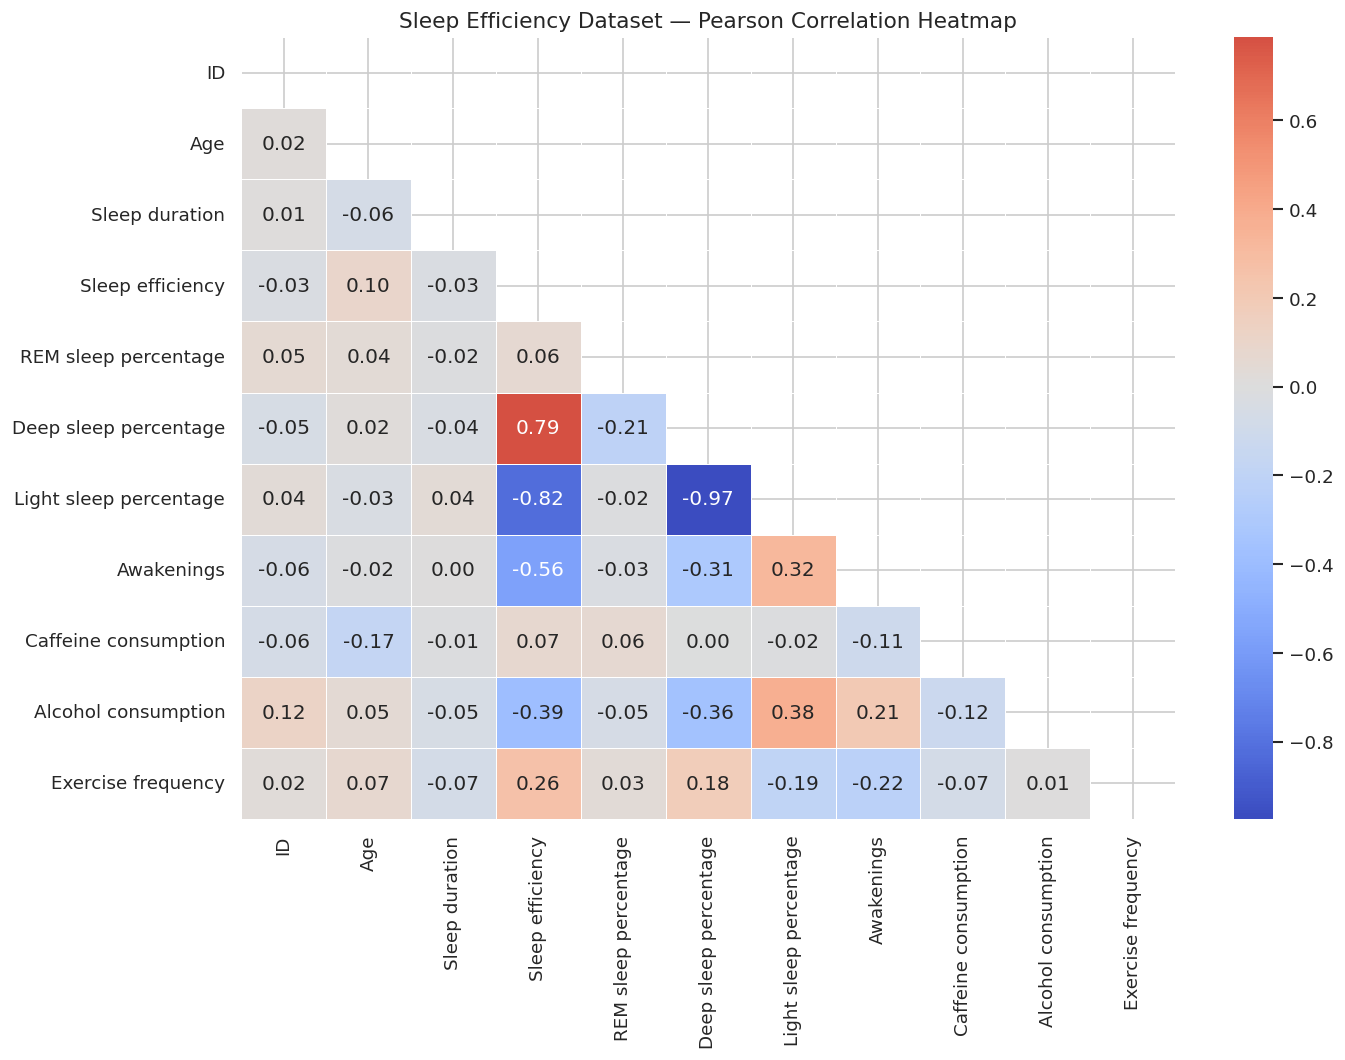

In [6]:
numeric_sleep = df_sleep.select_dtypes(include='number')
corr_matrix   = numeric_sleep.corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, linewidths=0.5, ax=ax
)
ax.set_title('Sleep Efficiency Dataset — Pearson Correlation Heatmap', fontsize=13)
plt.tight_layout()
plt.show()

### 3.2 Univariate Distributions
Histograms with KDE overlays for the key numeric columns.

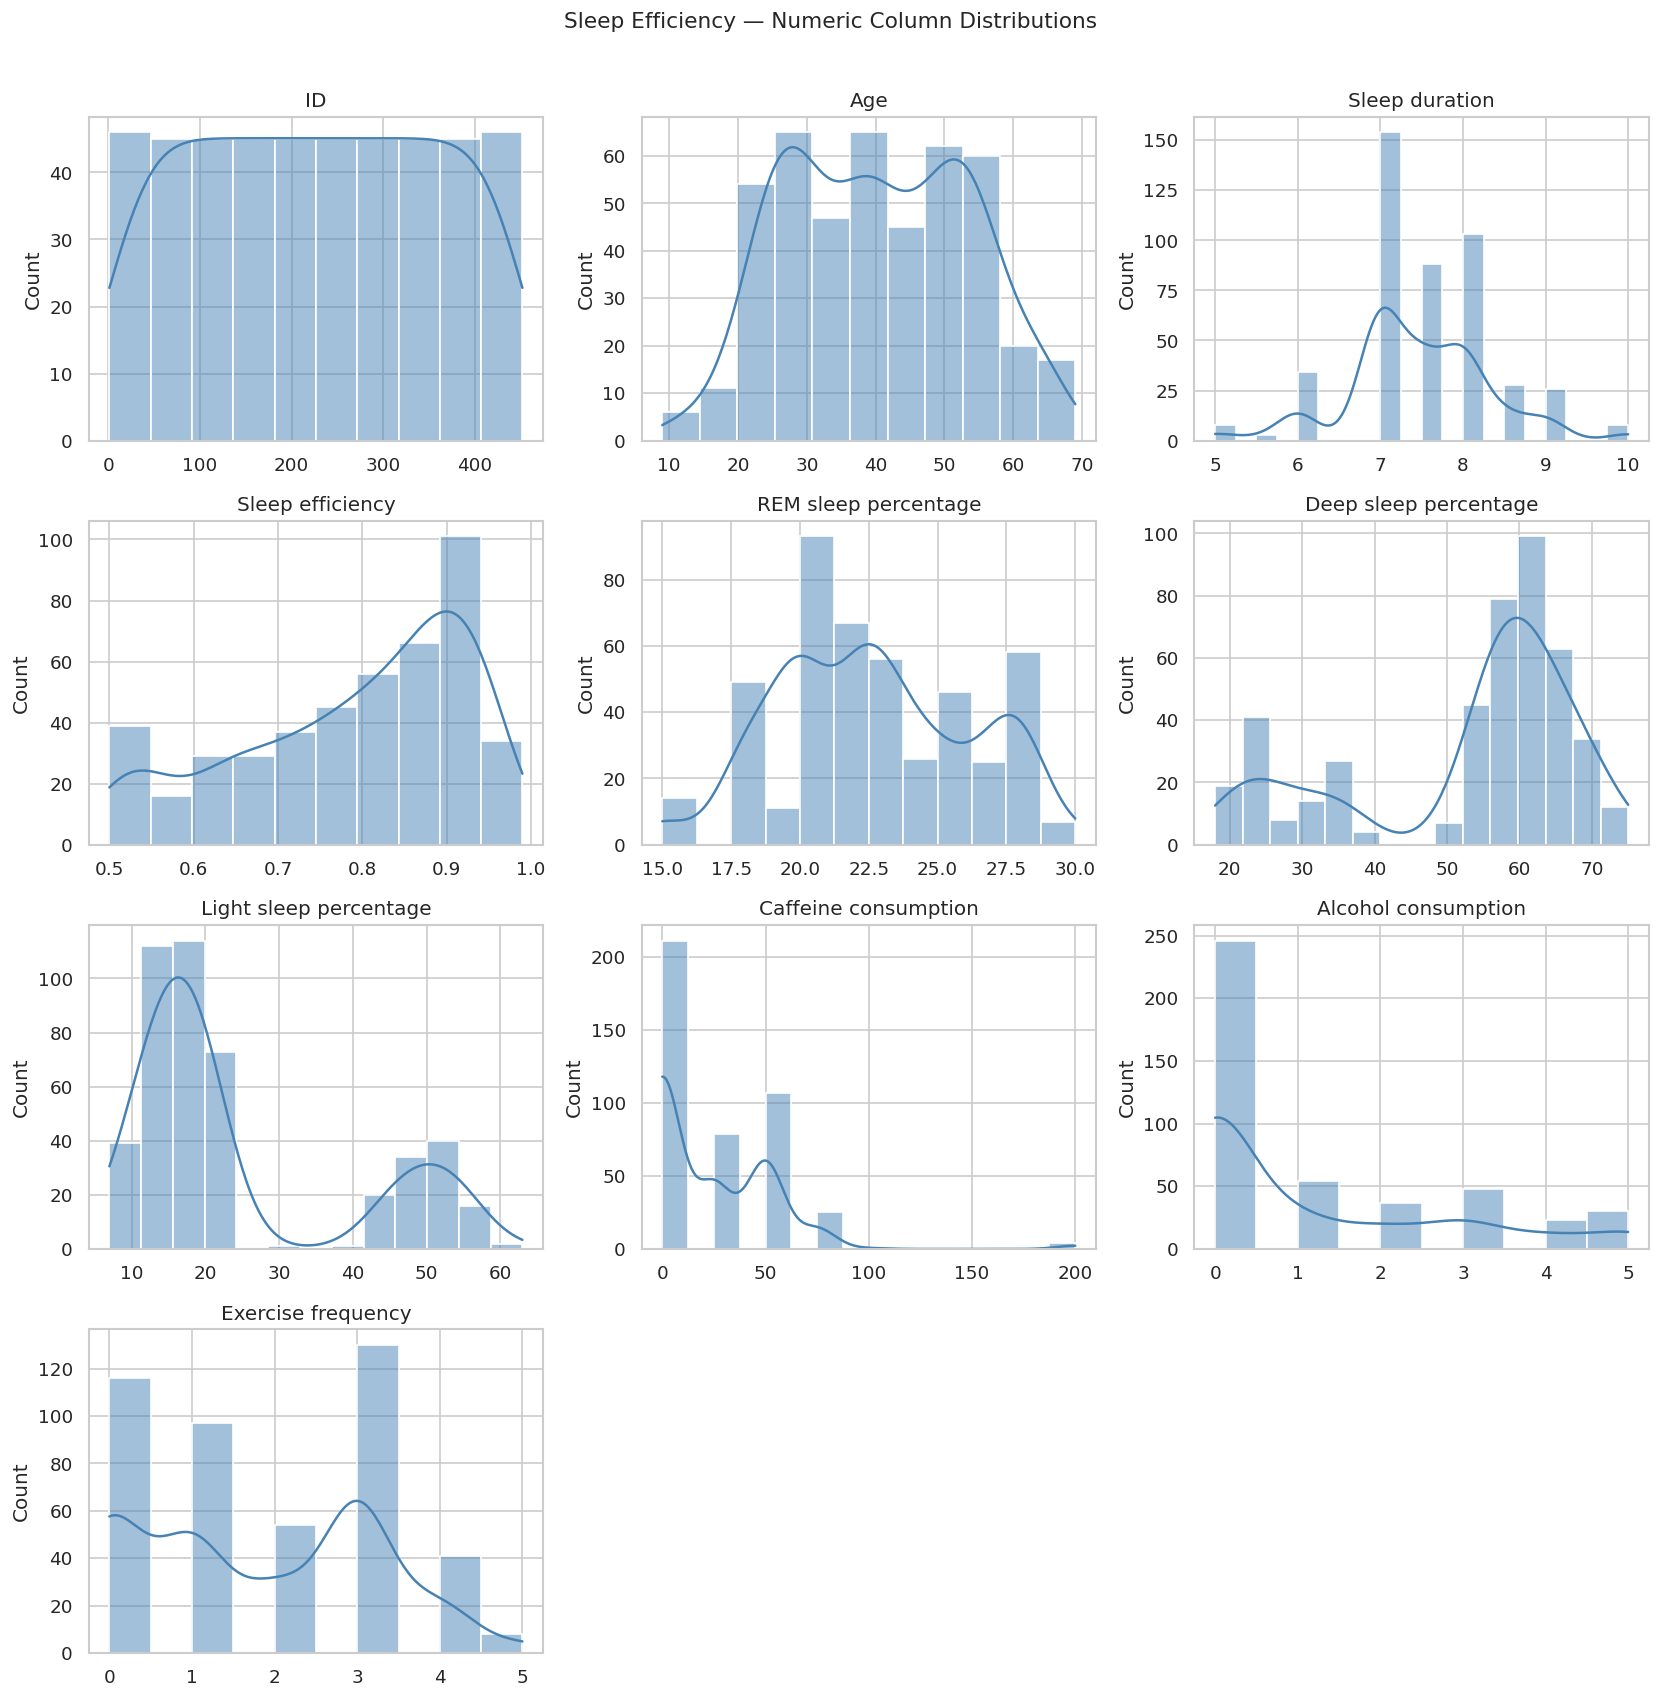

In [7]:
key_cols = [c for c in numeric_sleep.columns if numeric_sleep[c].nunique() > 5]
n_cols   = 3
n_rows   = int(np.ceil(len(key_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(key_cols):
    sns.histplot(df_sleep[col].dropna(), kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Sleep Efficiency — Numeric Column Distributions', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 3.3 Boxplots by Gender
Comparing sleep efficiency and sleep duration across genders.

/tmp/ipykernel_5308/917943829.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sleep, x='Gender', y=col, palette='Set2', ax=ax)
/tmp/ipykernel_5308/917943829.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sleep, x='Gender', y=col, palette='Set2', ax=ax)


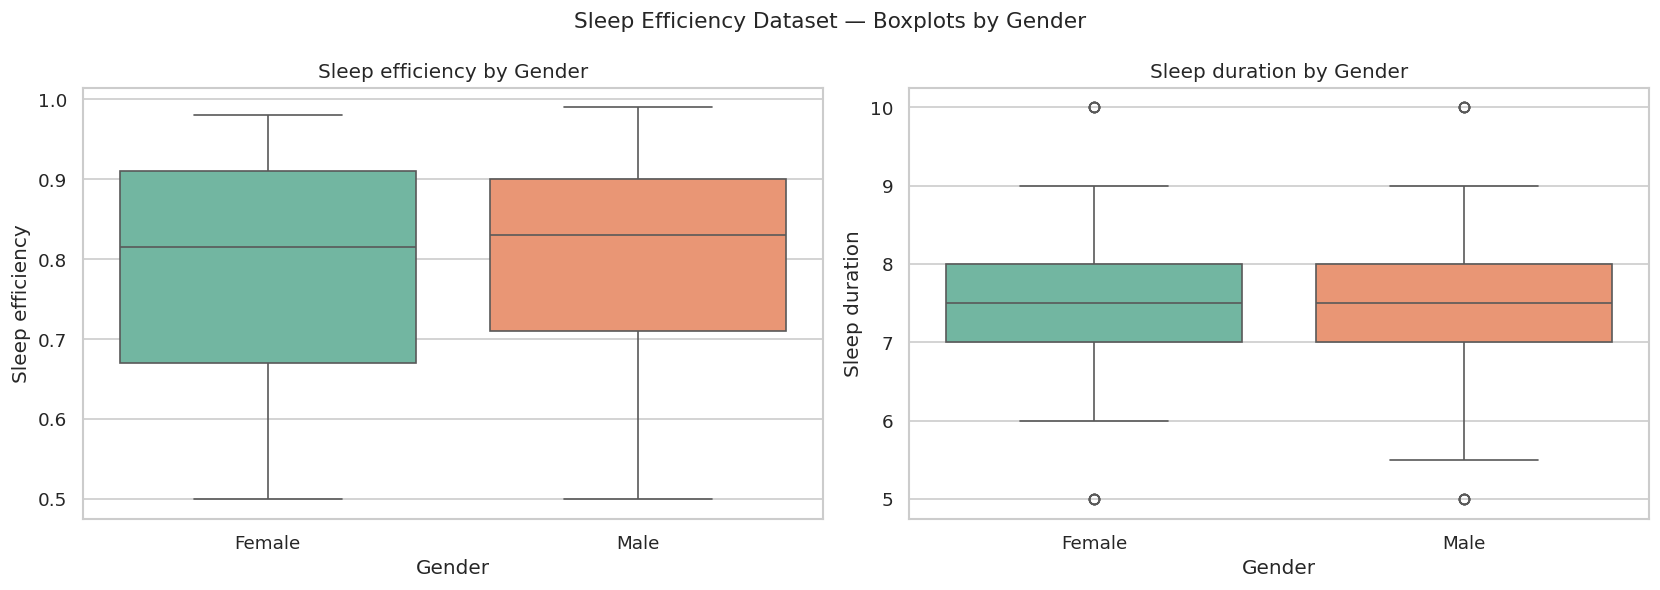

In [8]:
box_targets = ['Sleep efficiency', 'Sleep duration']
box_targets = [c for c in box_targets if c in df_sleep.columns]

if 'Gender' in df_sleep.columns and box_targets:
    fig, axes = plt.subplots(1, len(box_targets), figsize=(7 * len(box_targets), 5))
    if len(box_targets) == 1:
        axes = [axes]
    for ax, col in zip(axes, box_targets):
        sns.boxplot(data=df_sleep, x='Gender', y=col, palette='Set2', ax=ax)
        ax.set_title(f'{col} by Gender')
    plt.suptitle('Sleep Efficiency Dataset — Boxplots by Gender', fontsize=13)
    plt.tight_layout()
    plt.show()
else:
    print('Gender column not found or no target columns available.')

---
## 4. Room Occupancy EDA <a id='section-4'></a>
The **Room Occupancy** dataset provides dense multi-sensor time-series (temperature, light, sound, CO2, humidity) labelled by occupancy status. We explore trends and frequency content.

In [9]:
print(df_occ.dtypes)
df_occ.head()

date                        str
Temperature             float64
Humidity                float64
Light                   float64
CO2                     float64
HumidityRatio           float64
Occupancy                 int64
datetime         datetime64[us]
dtype: object


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,datetime
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2015-02-02 14:19:00
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2015-02-02 14:19:59
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2015-02-02 14:21:00
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2015-02-02 14:22:00
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2015-02-02 14:23:00


### 4.1 Multi-sensor Time-series Plot
Plotting the first 2000 samples of each sensor channel.

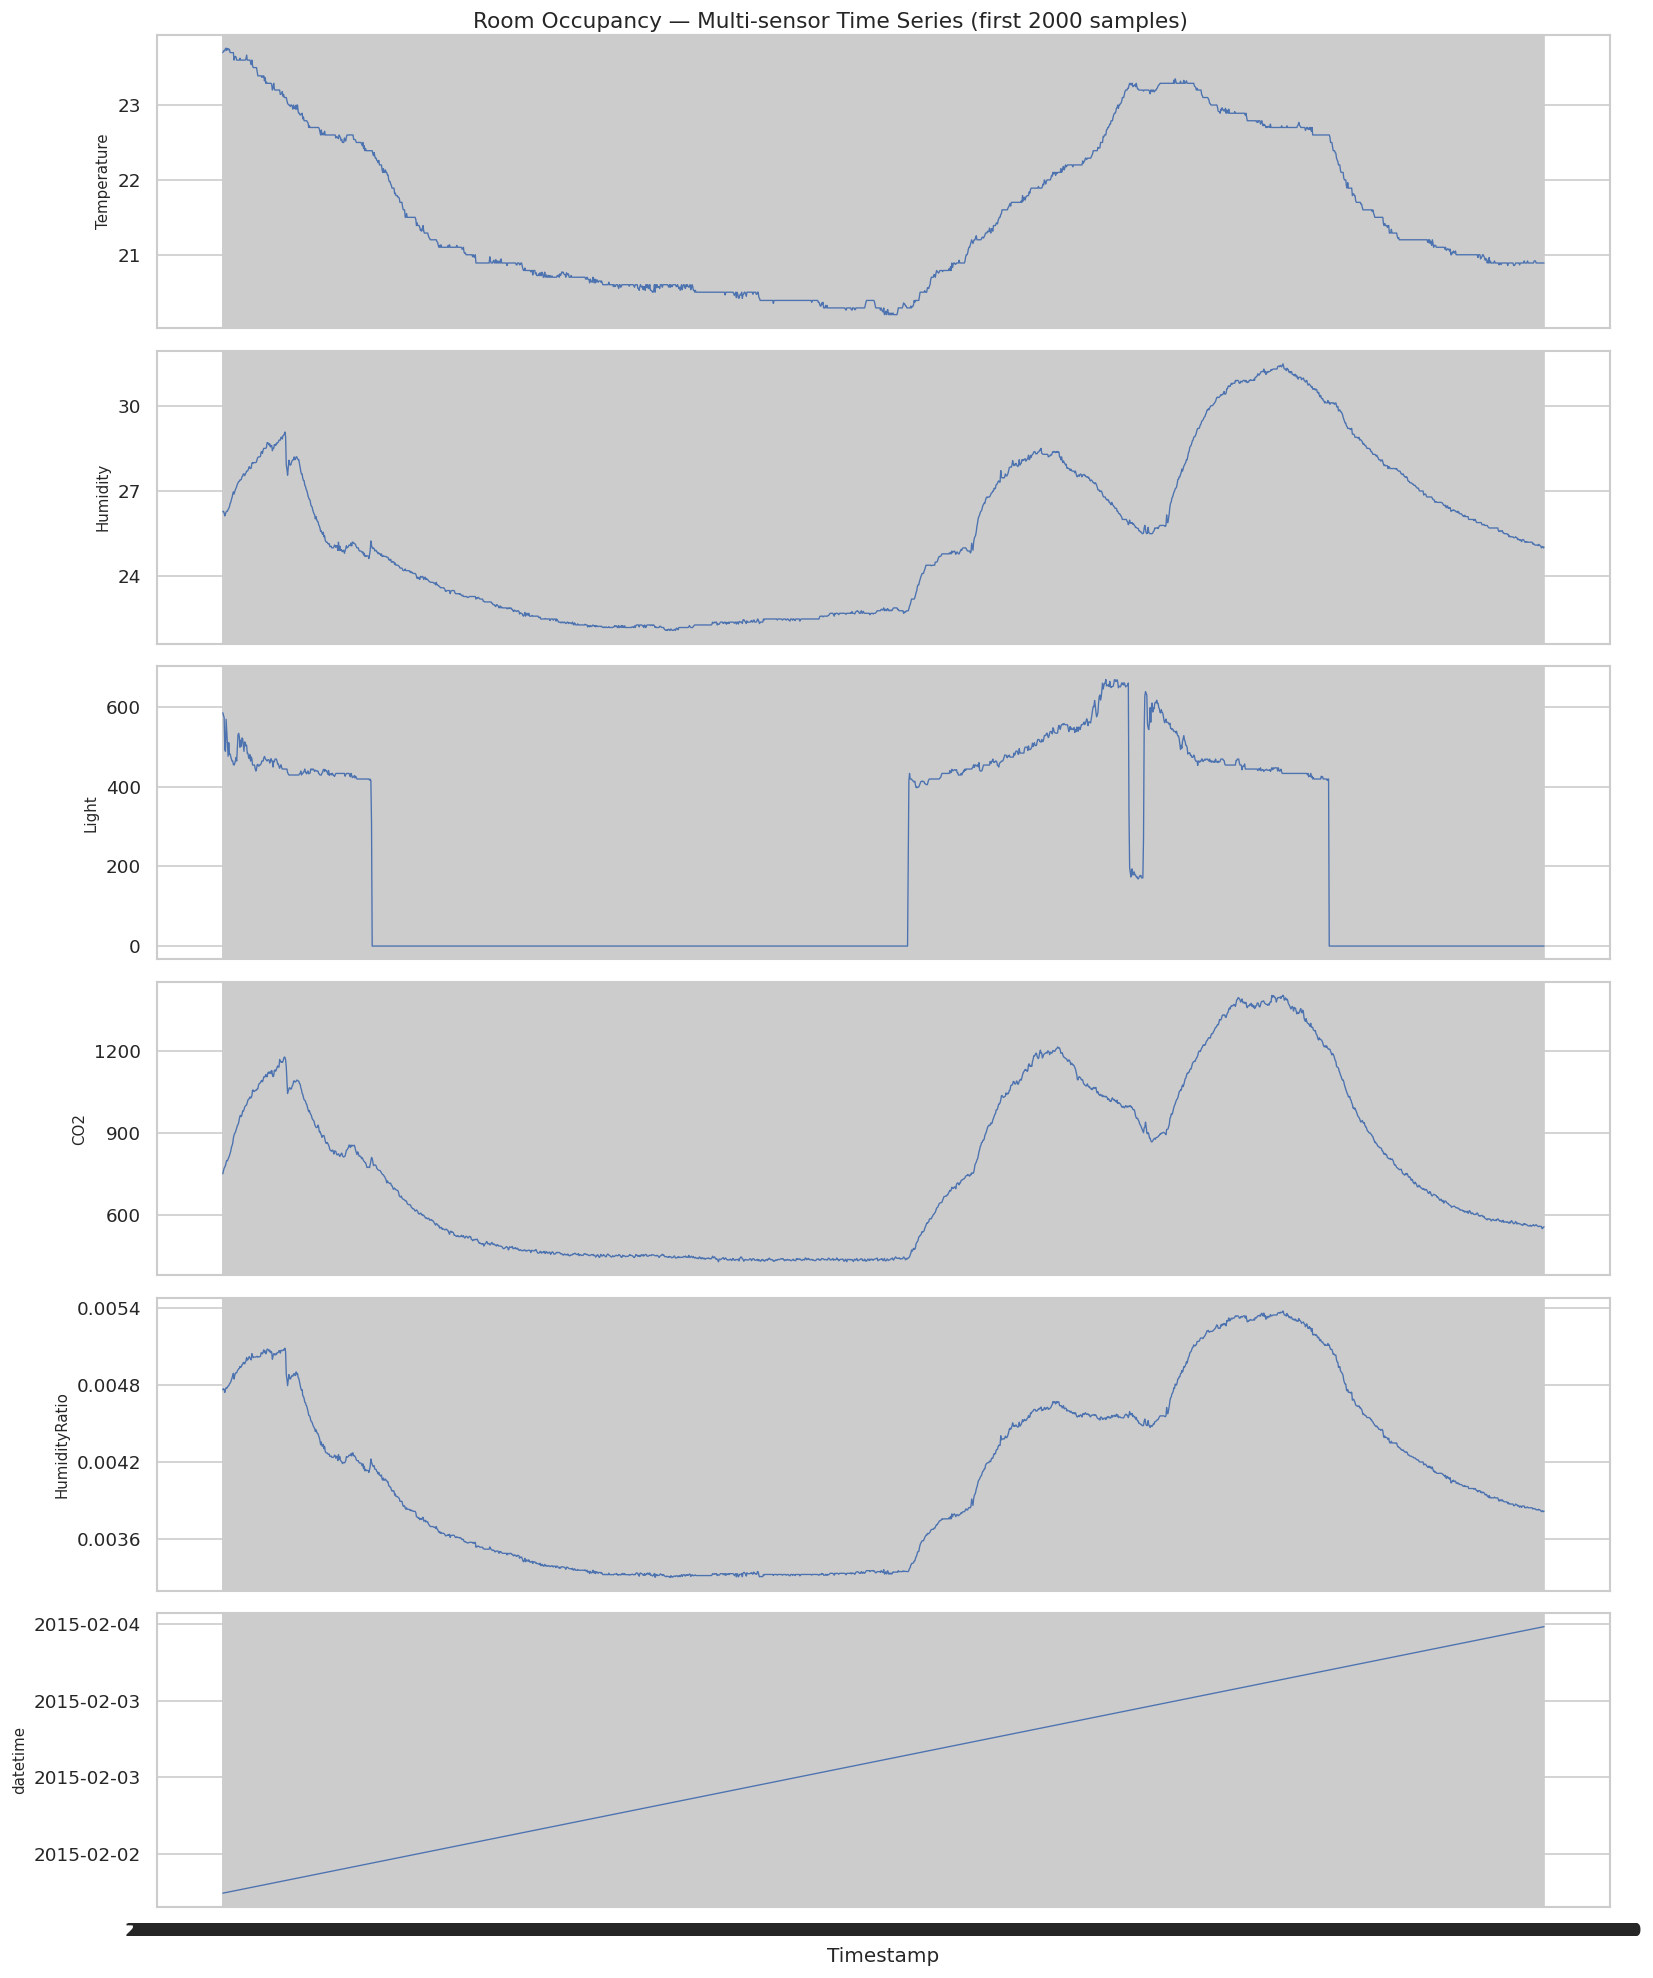

In [10]:
# Identify a datetime column if present
time_col  = next((c for c in df_occ.columns if 'date' in c.lower() or 'time' in c.lower()), None)
sensor_cols = [c for c in df_occ.columns
               if c not in ([time_col] if time_col else []) + ['Occupancy', 'occupancy']]

plot_n = min(2000, len(df_occ))
x_vals = df_occ[time_col].iloc[:plot_n] if time_col else np.arange(plot_n)

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(14, 2.8 * len(sensor_cols)), sharex=True)
if len(sensor_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, sensor_cols):
    ax.plot(x_vals, df_occ[col].iloc[:plot_n], linewidth=0.8)
    ax.set_ylabel(col, fontsize=9)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

axes[-1].set_xlabel('Sample index' if not time_col else 'Timestamp')
fig.suptitle('Room Occupancy — Multi-sensor Time Series (first 2000 samples)', fontsize=13)
plt.tight_layout()
plt.show()

### 4.2 FFT of Temperature Channel
A Fast Fourier Transform reveals dominant periodic components in the room temperature signal.

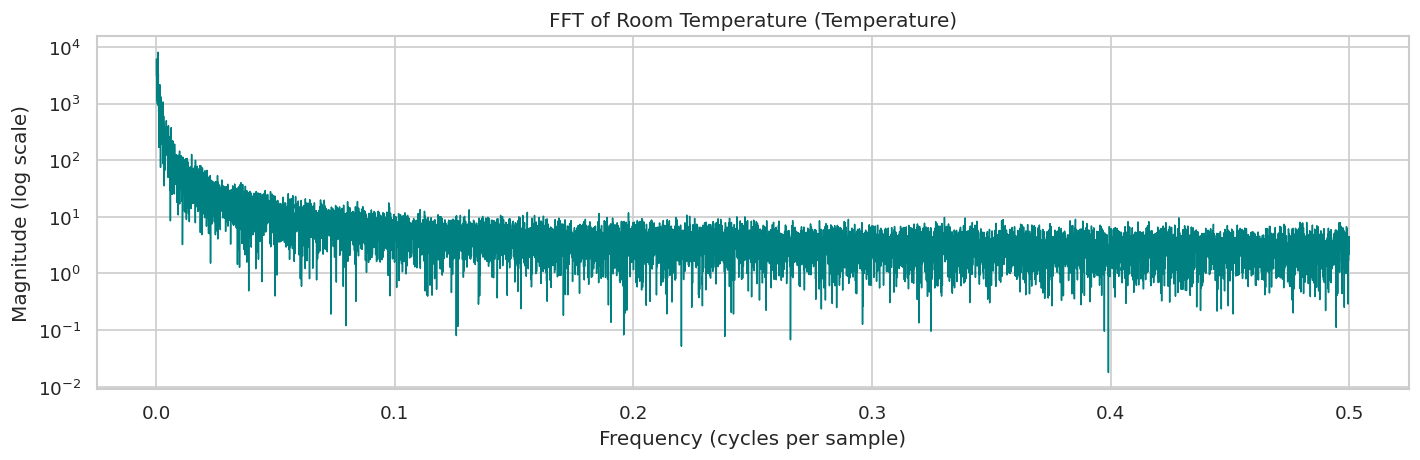

In [11]:
temp_col = next((c for c in df_occ.columns if 'temp' in c.lower()), None)

if temp_col:
    temp_vals = df_occ[temp_col].dropna().values
    N   = len(temp_vals)
    fs  = 1.0           # 1 sample per minute assumed
    fft_vals = np.abs(np.fft.rfft(temp_vals - temp_vals.mean()))
    freqs    = np.fft.rfftfreq(N, d=1/fs)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.semilogy(freqs[1:], fft_vals[1:], linewidth=0.9, color='teal')
    ax.set_xlabel('Frequency (cycles per sample)')
    ax.set_ylabel('Magnitude (log scale)')
    ax.set_title(f'FFT of Room Temperature ({temp_col})')
    plt.tight_layout()
    plt.show()
else:
    print('No temperature column found in Room Occupancy dataset.')

### 4.3 Autocorrelation of Temperature
Autocorrelation quantifies how much future values of temperature depend on past values — useful for designing realistic synthetic signals.

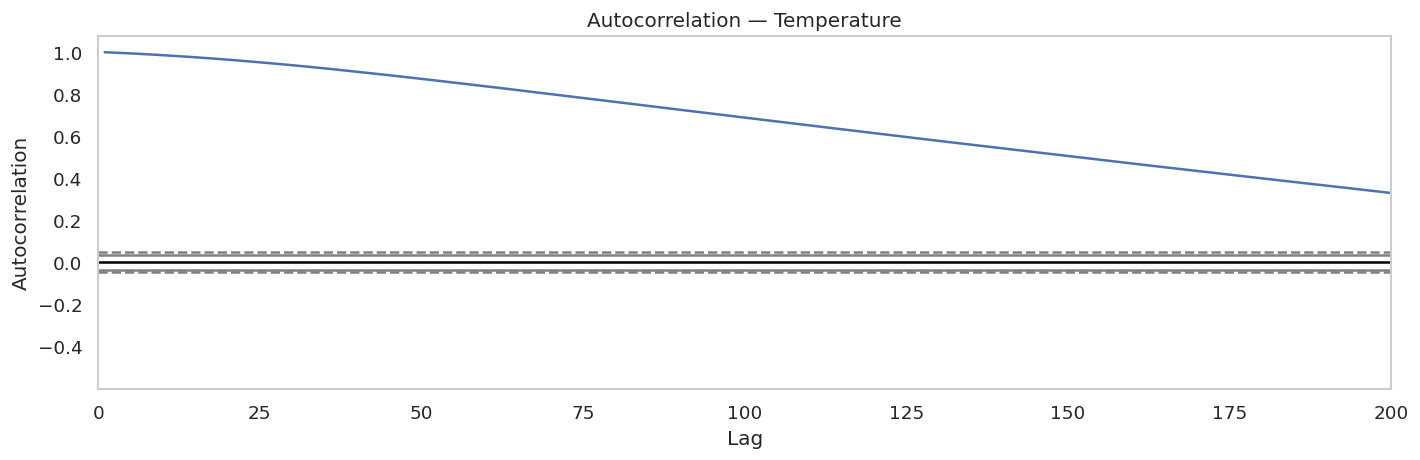

In [12]:
if temp_col:
    from pandas.plotting import autocorrelation_plot
    fig, ax = plt.subplots(figsize=(12, 4))
    autocorrelation_plot(df_occ[temp_col].dropna().iloc[:3000], ax=ax)
    ax.set_title(f'Autocorrelation — {temp_col}')
    ax.set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

---
## 5. Smart Home EDA <a id='section-5'></a>
Load the smart home dataset if available and inspect its basic statistics.

In [13]:
if df_home is not None:
    print(f'Shape : {df_home.shape}')
    print(f'dtypes:\n{df_home.dtypes}')
    print('\nDescriptive statistics:')
    display(df_home.describe())
    print('\nNull counts:')
    print(df_home.isnull().sum())
else:
    print('Smart Home dataset not available — skipping section.')

Shape : (503911, 32)
dtypes:
time                       str
use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
icon                       str
humidity               float64
visibility             float64
summary                    str
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover                 str
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProb

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,...,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,0.014139,...,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936,202.356843,0.002598,38.694013,0.056453
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199,0.057967,0.014292,...,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,...,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,...,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000,148.000000,0.000000,24.600000,0.000000
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,...,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000,208.000000,0.000000,39.030000,0.000000
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,0.013100,...,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000,295.000000,0.000000,54.790000,0.000000
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,...,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.490000,0.840000



Null counts:
time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64


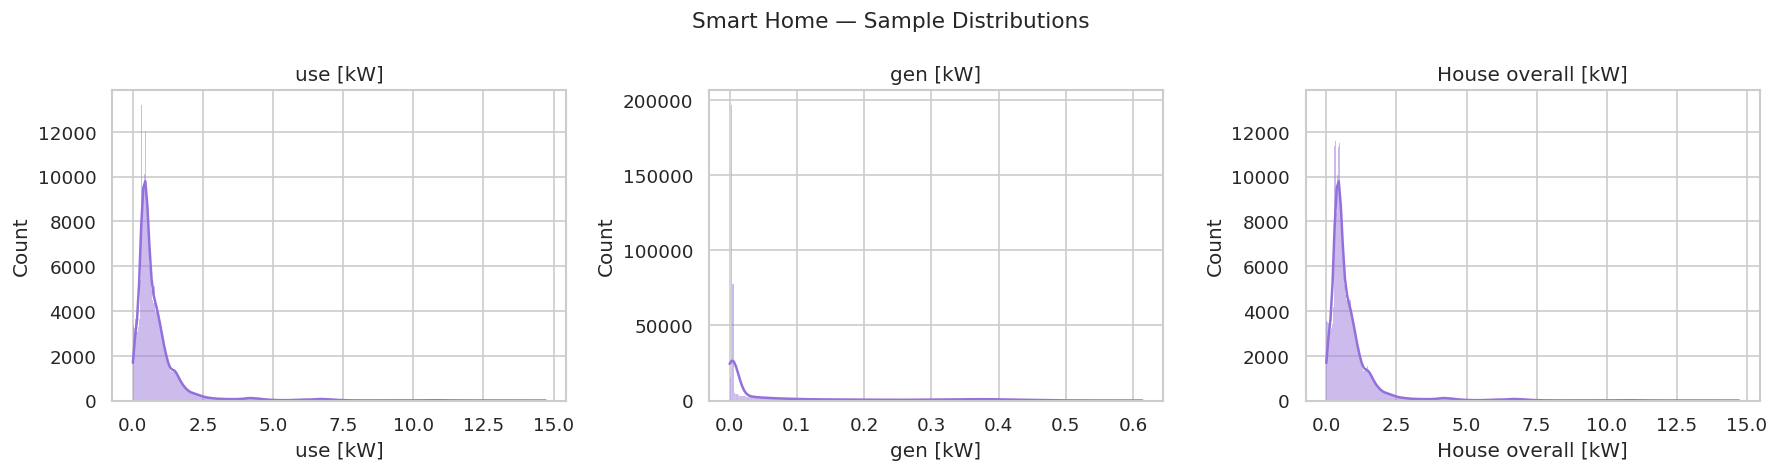

In [14]:
if df_home is not None:
    home_numeric = df_home.select_dtypes(include='number')
    if not home_numeric.empty:
        fig, axes = plt.subplots(1, min(3, len(home_numeric.columns)),
                                 figsize=(5 * min(3, len(home_numeric.columns)), 4))
        if not hasattr(axes, '__len__'):
            axes = [axes]
        for ax, col in zip(axes, home_numeric.columns[:3]):
            sns.histplot(home_numeric[col].dropna(), kde=True, ax=ax, color='mediumpurple')
            ax.set_title(col)
        plt.suptitle('Smart Home — Sample Distributions', fontsize=13)
        plt.tight_layout()
        plt.show()

---
## 6. Reference Statistics Summary <a id='section-6'></a>
`FeatureExtractor.extract_reference_stats()` aggregates key distributional statistics from all three datasets into a single dictionary used by the signal generator to produce realistic synthetic data.

In [15]:
import dataclasses

# ReferenceStats is a dataclass — extract calibration values from all loaded datasets
ref_stats = loader.extract_reference_stats()

print('=== Reference Calibration Statistics ===')
for field in dataclasses.fields(ref_stats):
    val = getattr(ref_stats, field.name)
    print(f'  {field.name}: {val}')

=== Reference Calibration Statistics ===
  temp_mean: 20.29963881468289
  temp_std: 0.4561006011635003
  temp_min: 19.39
  temp_max: 21.0
  temp_autocorr_lag1: 0.9964229308665901
  temp_dominant_freq_cpm: 0.00029682398337785694
  light_night_mean: 0.0
  light_night_std: 0.5
  light_event_lambda: 2.0
  light_event_duration_mean: 8.0
  sleep_efficiency_mean: 0.7889159292035398
  sleep_efficiency_std: 0.13523707364166557
  awakenings_mean: 1.6412037037037037
  rem_pct_mean: 22.615044247787612
  deep_pct_mean: 52.823008849557525
  light_pct_mean: 24.561946902654867
  top_correlated_features: ['Sleep efficiency', 'Light sleep percentage', 'Deep sleep percentage', 'Awakenings', 'Alcohol consumption', 'Exercise frequency', 'Age', 'Caffeine consumption', 'REM sleep percentage', 'Sleep duration']
  hvac_period_min: 60.52245976459284


In [16]:
print('Notebook 01 complete.')

Notebook 01 complete.
